# Simulate stochastic process

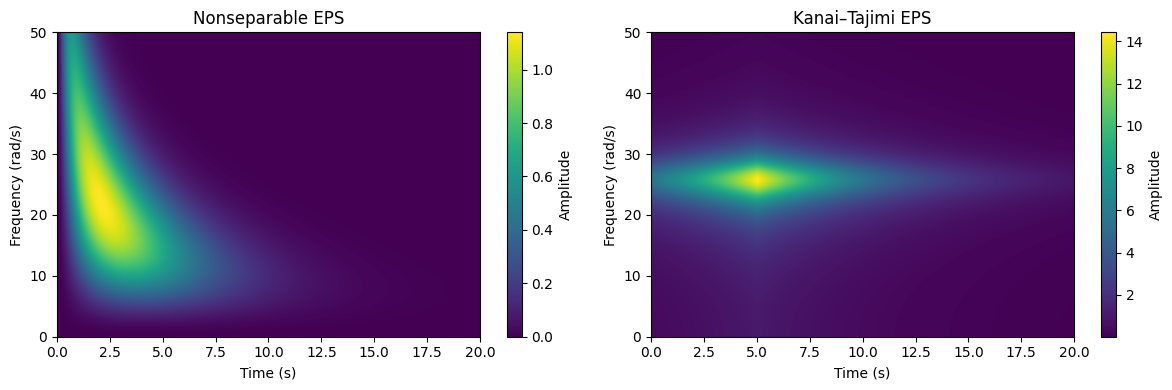

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

from eps.nonsep import nonseparable_evolutionary_power_spectrum
from eps.kt import kt_evolutionary_power_spectrum

time = np.linspace(0, 20, 512)
freq = np.linspace(0, 50, 512)

X, Y = np.meshgrid(time, freq)

eps_cp = np.zeros((len(time), len(freq)))
eps_kt = np.zeros((len(time), len(freq)))

#EPSs parameters
S0 = 1
b0 = 0.47500000000000003

#KT parameter
omega_g = 26.25
zeta_g = 0.1375

for i in range(len(time)):
    for j in range(len(freq)):
        eps_cp[i][j] = nonseparable_evolutionary_power_spectrum(freq[j], time[i], S0, b0)
        eps_kt[i][j] = kt_evolutionary_power_spectrum(freq[j], time[i], S0, omega_g, zeta_g, b0, 5)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

im0 = axes[0].imshow(
    eps_cp.T,                  # transpose so freq is y-axis
    extent=[time.min(), time.max(), freq.min(), freq.max()],
    origin='lower',
    aspect='auto',
    cmap=cm.viridis
)
axes[0].set_title("Nonseparable EPS")
axes[0].set_xlabel("Time (s)")
axes[0].set_ylabel("Frequency (rad/s)")
fig.colorbar(im0, ax=axes[0], label="Amplitude")

im1 = axes[1].imshow(
    eps_kt.T,                  # transpose so freq is y-axis
    extent=[time.min(), time.max(), freq.min(), freq.max()],
    origin='lower',
    aspect='auto',
    cmap=cm.viridis
)
axes[1].set_title("Kanai–Tajimi EPS")
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("Frequency (rad/s)")
fig.colorbar(im1, ax=axes[1], label="Amplitude")

plt.tight_layout()
plt.show()

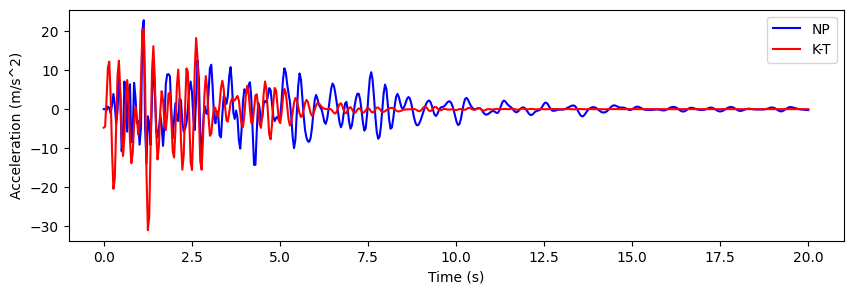

In [80]:
from simulate_process import simulate_process
import pandas as pd

w_cp = np.zeros((200, len(time)))
w_kt = np.zeros((200, len(time)))

for i in range(w_cp.shape[0]):
    w_cp[i,:] = simulate_process(time, S0, max(freq), omega_g, zeta_g, b0)
    w_kt[i,:] = simulate_process(time, S0, omega_g, omega_g, zeta_g, b0, eps_type='kt')

fig = plt.figure(figsize=(10,3))

plt.plot(time, w_cp[10,:], 'b')
plt.plot(time, w_kt[10,:], 'r')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s^2)')
plt.legend(['NP', 'K-T'])
plt.show()

w_cp_df = pd.DataFrame(w_cp.T).add_prefix('cp_')
w_kt_df = pd.DataFrame(w_kt.T).add_prefix('kt_')

df_results = pd.concat([w_cp_df, w_kt_df], axis=1)
df_results['time'] = time
df_results.to_csv(f'data/realizations/stochastic_process_{S0}_{b0}_{omega_g}_{zeta_g}.csv', index=False)

# GHW

In [3]:
import numpy as np
import pandas as pd
from wavelet.get_band_options import ghw_band_options

#df = pd.read_csv(f'data/realizations/stochastic_process_{S0}_{b0}_{omega_g}_{zeta_g}.csv')
df = pd.read_csv(f'data/realizations/stochastic_process_0.5_0.4_38.75_0.25_freq_cp_50.0_freq_kt_38.75.csv')

t = df["time"].values
x = df["cp_1"].values

dt = np.diff(t)
fs = 1.0 / np.median(dt)
print(f"Estimated fs = {fs:.2f} Hz")
print(f"Max dt = {max(dt):.4f} s")

# bands
bins_per_band = 4
uniform_bands, adaptive_bands, freqs = ghw_band_options(x, fs, bins_per_band=bins_per_band, spike_prominence=1e-1)

Estimated fs = 25.55 Hz
Max dt = 0.0391 s


In [4]:
from wavelet.ghw_transform import ghw_transform

# Apply GHW
out_uniform = ghw_transform(x, fs, uniform_bands, analytic=True, return_downsampled=False)
out_adaptive = ghw_transform(x, fs, adaptive_bands, analytic=True, return_downsampled=False)

# Extract coefficients and bands from ghw_transform output
coeffs = out_uniform["complex"]    # list of arrays per band
bands = out_uniform["bands"]       # (flo, fhi) Hz

num_bands = len(coeffs)

In [7]:
np.array(coeffs).shape

(65, 512)

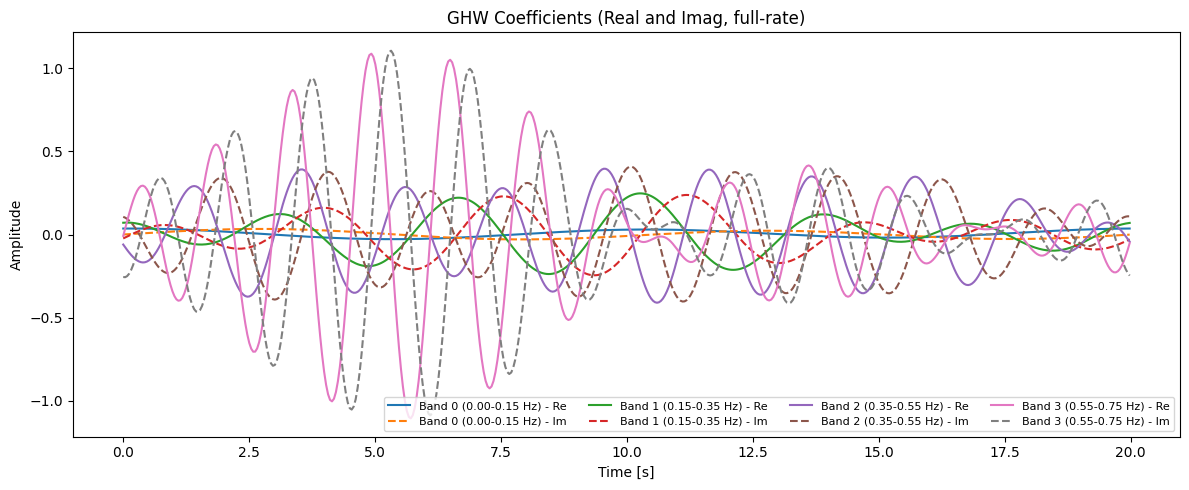

In [83]:
import numpy as np
import matplotlib.pyplot as plt

time = np.linspace(0, 40, 1024)
dt = time[1] - time[0]
t_original = np.arange(len(x)) * dt

plt.figure(figsize=(12,5))
n_bands_to_plot = 4 

for i in range(min(n_bands_to_plot, len(coeffs))):
    c = coeffs[i]
    plt.plot(t_original, c.real, label=f"Band {i} ({bands[i,0]:.2f}-{bands[i,1]:.2f} Hz) - Re")
    plt.plot(t_original, c.imag, "--", label=f"Band {i} ({bands[i,0]:.2f}-{bands[i,1]:.2f} Hz) - Im")

plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.title("GHW Coefficients (Real and Imag, full-rate)")
plt.legend(fontsize=8, ncol=n_bands_to_plot)
plt.tight_layout()
plt.show()

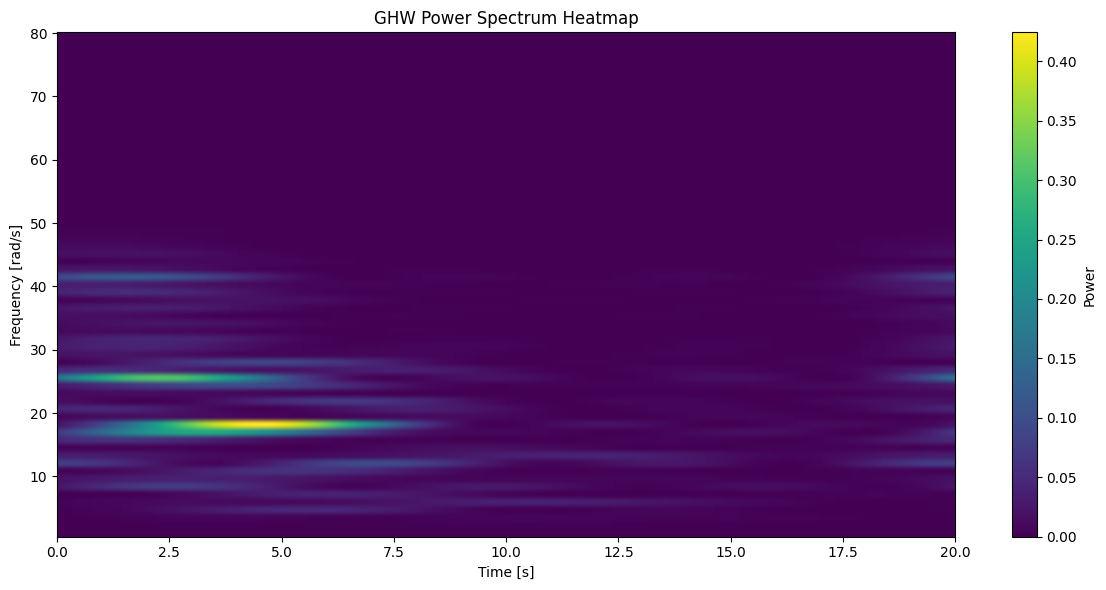

In [84]:
import numpy as np
import matplotlib.pyplot as plt

time = np.linspace(0,20,512)
power_matrix = np.array([np.abs(c)**2/(2*np.pi*4) for c in coeffs])
freq_centers = 2*np.pi*np.array([(b[0]+b[1])/2 for b in bands])

plt.figure(figsize=(12,6))
plt.imshow(power_matrix, aspect='auto', origin='lower',
           extent=[time[0], time[-1], freq_centers[0], freq_centers[-1]])
plt.colorbar(label='Power')
plt.xlabel("Time [s]")
plt.ylabel("Frequency [rad/s]")
plt.title("GHW Power Spectrum Heatmap")
plt.tight_layout()
plt.show()

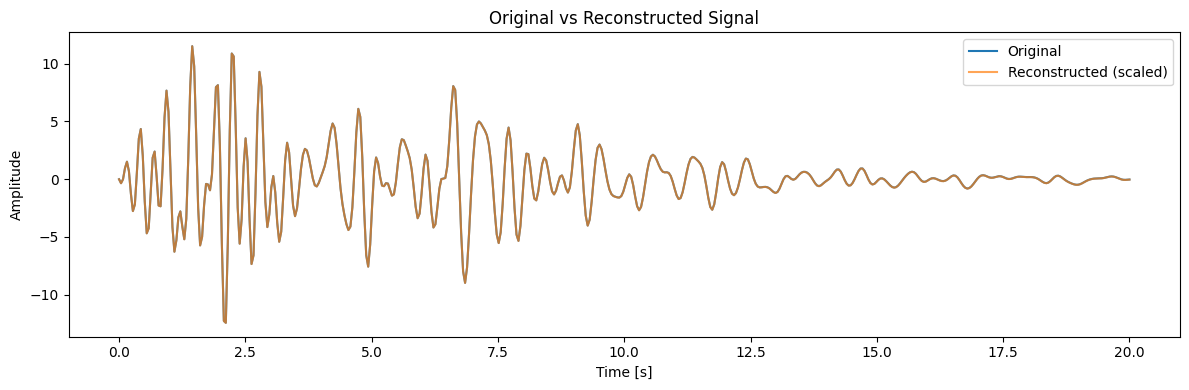

In [67]:
x_rec = out_uniform["reconstruct_fullrate"]()

# Scale to match original signal RMS
scale = np.std(x) / np.std(x_rec)
x_rec_scaled = x_rec * scale

plt.figure(figsize=(12,4))
plt.plot(time, x, label="Original")
plt.plot(time, x_rec_scaled, label="Reconstructed (scaled)", alpha=0.7)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.title("Original vs Reconstructed Signal")
plt.legend()
plt.tight_layout()
plt.show()


# Get coef

data/transformations/stochastic_process_1.0_0.4_38.75_0.1375_freq_cp_50.0_freq_kt_38.75_cp_140.pkl


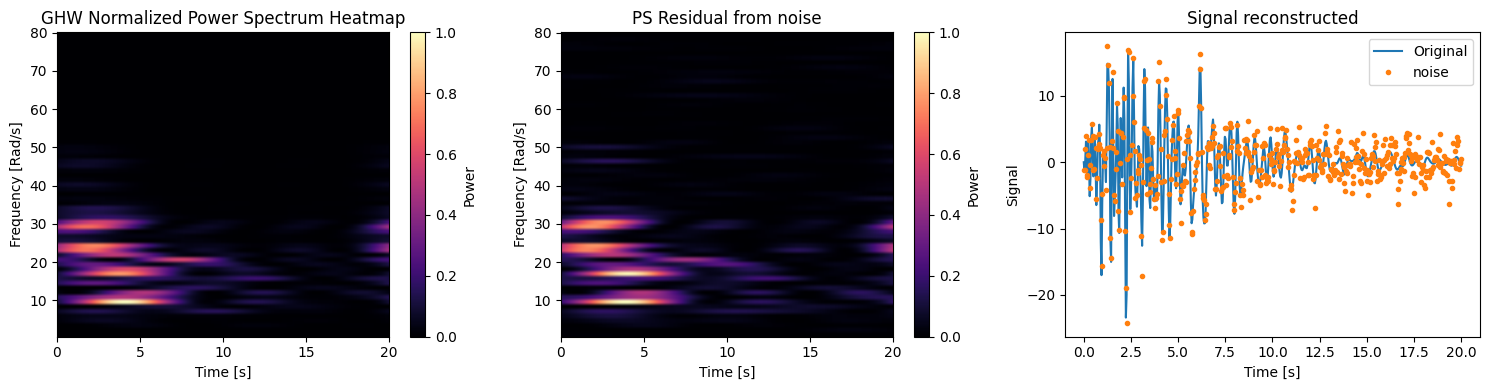

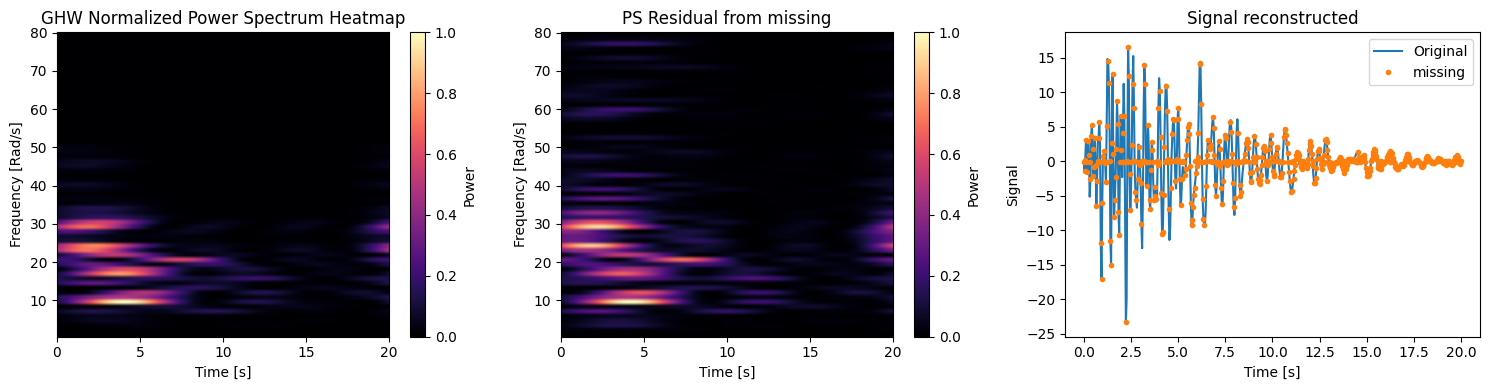

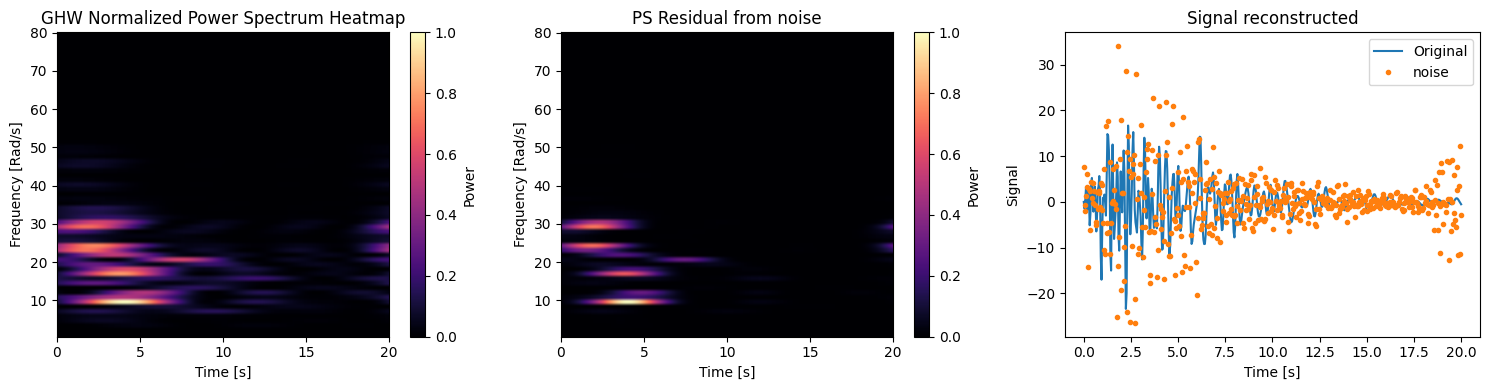

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_power(df: pd.DataFrame, df_aux = None, tmax: float = 20, timesteps: int = 512, width = 4, df_type = None): 
    time = np.linspace(0, tmax, timesteps)
    freq_centers = 2*np.pi*df['freq_centers'].values
    coeffs = df.drop(columns='freq_centers')
    power_matrix = np.array([np.abs(c)**2/(2*np.pi*width) for c in coeffs.values])
    normalized_power_matrix = (power_matrix - power_matrix.min()) / (power_matrix.max() - power_matrix.min())

    if df_aux is not None:
        coeffs_aux = df_aux.drop(columns='freq_centers')
        power_matrix_aux = np.array([np.abs(coeffs_aux)**2/(2*np.pi*width) for coeffs_aux in coeffs_aux.values])
        normalized_power_matrix_aux = (power_matrix_aux - power_matrix_aux.min()) / (power_matrix_aux.max() - power_matrix_aux.min())

    if df_aux is None:
        fig = plt.figure(figsize=(8,4))
        plt.subplot(1,2,1)
        plt.imshow(normalized_power_matrix, aspect='auto', origin='lower', extent=[time[0], time[-1], freq_centers[0], freq_centers[-1]], cmap='magma')
        plt.colorbar(label='Power')
        plt.xlabel("Time [s]")
        plt.ylabel("Frequency [Rad/s]")
        plt.title("GHW Normalized Power Spectrum Heatmap")

        plt.subplot(1,2,2)
        reconstructed_signal = np.sum(coeffs.values.real, axis=0)
        plt.plot(time, reconstructed_signal)
        plt.xlabel("Time [s]")
        plt.ylabel("Signal")
        plt.title("Signal reconstructed")

    else:
        fig = plt.figure(figsize=(15,4))
        plt.subplot(1,3,1)
        plt.imshow(normalized_power_matrix, aspect='auto', origin='lower', extent=[time[0], time[-1], freq_centers[0], freq_centers[-1]], cmap='magma')
        plt.colorbar(label='Power')
        plt.xlabel("Time [s]")
        plt.ylabel("Frequency [Rad/s]")
        plt.title("GHW Normalized Power Spectrum Heatmap")

        plt.subplot(1,3,2)
        plt.imshow(np.abs(normalized_power_matrix_aux), aspect='auto', origin='lower', extent=[time[0], time[-1], freq_centers[0], freq_centers[-1]], cmap='magma')
        plt.colorbar(label='Power')
        plt.xlabel("Time [s]")
        plt.ylabel("Frequency [Rad/s]")
        plt.title(f"PS Residual from {df_type}")

        plt.subplot(1,3,3)
        reconstructed_signal = np.sum(coeffs.values.real, axis=0)
        reconstructed_signal_aux = np.sum(coeffs_aux.values.real, axis=0)
        plt.plot(time, reconstructed_signal)
        plt.plot(time, reconstructed_signal_aux, '.')
        plt.legend(['Original', f'{df_type}'])
        plt.xlabel("Time [s]")
        plt.ylabel("Signal")
        plt.title("Signal reconstructed")

    plt.tight_layout()
    plt.show()

import os

directory_path = 'data/transformations/'

all_files = [os.path.join(directory_path, f) for f in os.listdir(directory_path) 
                if os.path.isfile(os.path.join(directory_path, f))]

all_files = [f for f in all_files if 'noisy' not in f and 'missing' not in f]

filename = all_files[10]
print(filename)
df : pd.DataFrame = pd.read_pickle(filename)
df_noisy : pd.DataFrame = pd.read_pickle(f'{filename.split('.pkl')[0]}_noisy.pkl')
df_missing: pd.DataFrame = pd.read_pickle(f'{filename.split('.pkl')[0]}_missing.pkl')

df_nm = pd.DataFrame(df_noisy.drop(columns='freq_centers').values * df_missing.drop(columns='freq_centers').values)
df_nm['freq_centers'] = df_noisy['freq_centers']

plot_power(df, df_noisy, df_type='noise')
plot_power(df, df_missing, df_type='missing')
plot_power(df, df_nm, df_type='noise')

In [3]:
df.shape

(65, 513)

# Data Prep

In [ ]:
# train_vae_unet_ms_charbonnier_fixed_aux.py
import os, re, glob, math, random
from typing import List

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

# =========================================================
# Config (matches your settings)
# =========================================================
ROOT = "data/transformations"

SNR_DB_RANGE = (10.0, 30.0)   # corruption SNR range (original units)
Z_CHANNELS    = 8             # latent channels -> Cz x 16 x 32
BASE_CH       = 64            # UNet base channels

EPOCHS        = 40
LR            = 2e-4
WEIGHT_DECAY  = 1e-4

# KL schedule
BETA_TARGET   = 1e-3          # gentler to favor recon early
WARMUP_EPOCHS = 5
FREE_NATS     = 0.01          # per-element free nats

# Normalization cache
STATS_PATH    = "cp_stats.npz"   # saves [mean,std] for Re/Im

# Multi-scale Charbonnier loss (normalized space)
USE_MS_LOSS   = True
EPS_CHARB     = 1e-3
MS_WEIGHTS    = (0.5, 0.3, 0.2)  # 1x, 1/2x, 1/4x

# Aux mag/phase (in ORIGINAL units) + warm-up
USE_AUX_MAGPHASE     = True
LAMBDA_MAG_TARGET    = 0.05
LAMBDA_PHASE_TARGET  = 0.02
AUX_WARMUP_EPOCHS    = 3        # ramp aux weights 0 -> target

# Repro
SEED = 42
torch.manual_seed(SEED); random.seed(SEED); np.random.seed(SEED)
torch.backends.cudnn.benchmark = True
if hasattr(torch, "set_float32_matmul_precision"):
    torch.set_float32_matmul_precision("medium")

# =========================================================
# File discovery / I/O
# =========================================================
CP_PATTERN = re.compile(r"cp_\d+\.pkl$")

def find_cp_pickles(root: str = ROOT) -> List[str]:
    candidates = glob.glob(os.path.join(root, "**", "*.pkl"), recursive=True)
    files = [f for f in candidates if CP_PATTERN.search(os.path.basename(f))]
    files.sort()
    return files

def load_one_cp(path: str) -> torch.Tensor:
    """Load .pkl, crop 65x513 -> 64x512, return (2,64,512) float32 [Re, Im]."""
    obj = pd.read_pickle(path)
    arr = obj.to_numpy() if isinstance(obj, pd.DataFrame) else np.asarray(obj)
    if arr.ndim != 2:
        raise ValueError(f"Expected 2D array in {path}, got shape {arr.shape}")
    arr = arr[:-1, :-1].astype(np.complex64, copy=False)
    re = arr.real.astype(np.float32, copy=False)
    im = arr.imag.astype(np.float32, copy=False)
    x = np.stack([re, im], axis=0)
    return torch.from_numpy(x)

# =========================================================
# Streaming mean/std (cached)
# =========================================================
@torch.no_grad()
def compute_or_load_stats(paths: List[str], stats_path: str = STATS_PATH, sample_limit: int = 0):
    if os.path.exists(stats_path):
        d = np.load(stats_path)
        mean = torch.from_numpy(d["mean"].astype(np.float32))
        std  = torch.from_numpy(d["std"].astype(np.float32))
        print(f"[stats] Loaded: mean={mean.tolist()} std={std.tolist()}")
        return mean, std

    n = len(paths) if sample_limit <= 0 else min(sample_limit, len(paths))
    print(f"[stats] Computing mean/std over {n} files ...")

    count = 0
    sum_all, ssq_all = None, None

    for p in paths[:n]:
        x = load_one_cp(p).double().contiguous()
        x_flat = x.reshape(2, -1)
        s = x_flat.sum(dim=1)
        ssq = (x_flat**2).sum(dim=1)
        if sum_all is None:
            sum_all, ssq_all = s.clone(), ssq.clone()
        else:
            sum_all += s; ssq_all += ssq
        count += x_flat.shape[1]

    mean = (sum_all / count).float()
    var  = (ssq_all / count - mean.double()**2).float().clamp_min(1e-8)
    std  = var.sqrt()
    np.savez(stats_path, mean=mean.numpy(), std=std.numpy())
    print(f"[stats] Saved: mean={mean.tolist()} std={std.tolist()}")
    return mean, std

# =========================================================
# Datasets
# =========================================================
class EPSPathsDataset(Dataset):
    def __init__(self, paths: List[str]): self.paths = paths
    def __len__(self): return len(self.paths)
    def __getitem__(self, idx: int) -> torch.Tensor: return load_one_cp(self.paths[idx])

class ComplexCorruptor:
    """Circularly-symmetric complex AWGN with per-sample SNR in [lo, hi] dB (applied in original units)."""
    def __init__(self, snr_db=(10.0, 30.0)): self.lo, self.hi = snr_db
    @torch.no_grad()
    def __call__(self, x: torch.Tensor):
        needs_batch = (x.dim() == 3)
        if needs_batch: x = x.unsqueeze(0)
        B = x.shape[0]; device = x.device
        mag2 = x[:,0]**2 + x[:,1]**2
        rms = torch.sqrt(mag2.mean(dim=(1,2), keepdim=True) + 1e-8)
        snr_db = torch.empty(B,1,1,1, device=device).uniform_(self.lo, self.hi)
        sigma = rms.view(B,1,1,1) * (10.0 ** (-snr_db/20.0))
        std = sigma / math.sqrt(2.0)
        y = x + torch.randn_like(x) * std
        snr_db_flat = snr_db.view(B)
        cond_norm = (snr_db_flat - self.lo) / (self.hi - self.lo)
        if needs_batch: y = y.squeeze(0)
        return y, {"snr_db": snr_db_flat, "cond_norm": cond_norm}

class Normalize:
    def __init__(self, mean: torch.Tensor, std: torch.Tensor):
        self.mean = mean.view(1, -1, 1, 1).float()
        self.std  = std.view(1, -1, 1, 1).float().clamp_min(1e-6)
    def __call__(self, x: torch.Tensor):
        if x.dim() == 3: x = x.unsqueeze(0)
        return (x - self.mean.to(x.device)) / self.std.to(x.device)
    def denorm(self, x: torch.Tensor):
        return x * self.std.to(x.device) + self.mean.to(x.device)

class DenoisingWrapper(Dataset):
    """Returns normalized (x_noisy, x_clean) and cond scalar in [0,1]."""
    def __init__(self, base: Dataset, corruptor: ComplexCorruptor, normalizer: Normalize):
        self.base = base; self.corrupt = corruptor; self.norm = normalizer
    def __len__(self): return len(self.base)
    def __getitem__(self, idx):
        x_clean = self.base[idx]
        x_noisy, meta = self.corrupt(x_clean)
        cond = meta["cond_norm"].float()
        return self.norm(x_noisy).squeeze(0), self.norm(x_clean).squeeze(0), cond

# =========================================================
# Model (U-Net + spatial latent + conditional prior)
# =========================================================
class Enc2DLatentCond(nn.Module):
    """Input: (B,3,64,512) -> mu, logvar: (B,Cz,16,32) + skips."""
    def __init__(self, in_ch=3, base=BASE_CH, z_channels=Z_CHANNELS):
        super().__init__()
        self.e0 = nn.Sequential(  # 64x512 -> 32x256
            nn.Conv2d(in_ch, base, 3, stride=(2,2), padding=1), nn.GroupNorm(8, base), nn.SiLU()
        )
        self.e1 = nn.Sequential(  # 32x256 -> 16x128
            nn.Conv2d(base, base*2, 3, stride=(2,2), padding=1), nn.GroupNorm(16, base*2), nn.SiLU()
        )
        self.e2 = nn.Sequential(  # 16x128 -> 16x64
            nn.Conv2d(base*2, base*4, 3, stride=(1,2), padding=1), nn.GroupNorm(16, base*4), nn.SiLU()
        )
        self.eb = nn.Sequential(  # 16x64 -> 16x32
            nn.Conv2d(base*4, base*4, 3, stride=(1,2), padding=1), nn.GroupNorm(16, base*4), nn.SiLU()
        )
        self.mu     = nn.Conv2d(base*4, z_channels, kernel_size=1)
        self.logvar = nn.Conv2d(base*4, z_channels, kernel_size=1)

    def forward(self, x_with_cond):
        f0 = self.e0(x_with_cond)   # (B, base,   32,256)
        f1 = self.e1(f0)            # (B, 2base,  16,128)
        f2 = self.e2(f1)            # (B, 4base,  16,64)
        fb = self.eb(f2)            # (B, 4base,  16,32)
        return self.mu(fb), self.logvar(fb), (f0, f1, f2)

class Dec2DLatentCondUNet(nn.Module):
    """U-Net decoder: upsample + concat skips. cond_lat_map is concatenated at latent resolution."""
    def __init__(self, out_ch=2, base=BASE_CH, z_channels=Z_CHANNELS):
        super().__init__()
        in_ch_lat = z_channels + 1
        self.proj = nn.Conv2d(in_ch_lat, base*4, kernel_size=1)
        self.up0 = nn.ConvTranspose2d(base*4, base*4, kernel_size=(3,4), stride=(1,2), padding=(1,1))
        self.c0  = nn.Sequential(nn.Conv2d(base*8, base*4, 3, padding=1), nn.GroupNorm(16, base*4), nn.SiLU())
        self.up1 = nn.ConvTranspose2d(base*4, base*2, kernel_size=(3,4), stride=(1,2), padding=(1,1))
        self.c1  = nn.Sequential(nn.Conv2d(base*4, base*2, 3, padding=1), nn.GroupNorm(16, base*2), nn.SiLU())
        self.up2 = nn.ConvTranspose2d(base*2, base, kernel_size=(4,4), stride=(2,2), padding=(1,1))
        self.c2  = nn.Sequential(nn.Conv2d(base*2, base, 3, padding=1), nn.GroupNorm(8, base), nn.SiLU())
        self.up3 = nn.ConvTranspose2d(base, out_ch, kernel_size=(4,4), stride=(2,2), padding=(1,1))

    def forward(self, z, cond_lat_map, skips):
        f0, f1, f2 = skips
        h = self.proj(torch.cat([z, cond_lat_map], dim=1))  # (B,4b,16,32)
        h = self.up0(h)                                     # 16x64
        h = self.c0(torch.cat([h, f2], dim=1))
        h = self.up1(h)                                     # 16x128
        h = self.c1(torch.cat([h, f1], dim=1))
        h = self.up2(h)                                     # 32x256
        h = self.c2(torch.cat([h, f0], dim=1))
        return self.up3(h)                                  # 64x512

class CondPrior(nn.Module):
    """p(z|c): scalar c -> (mu_p, logvar_p) broadcast to (B,Cz,16,32)."""
    def __init__(self, z_channels=Z_CHANNELS, hidden=64):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(1, hidden), nn.SiLU(), nn.Linear(hidden, 2*z_channels))
    def forward(self, cond_scalar: torch.Tensor, spatial_hw=(16,32)):
        B = cond_scalar.shape[0]; H, W = spatial_hw
        out = self.net(cond_scalar.view(B,1))
        mu_p, logvar_p = out.chunk(2, dim=1)
        mu_p = mu_p.view(B,-1,1,1).expand(B,-1,H,W)
        logvar_p = logvar_p.view(B,-1,1,1).expand(B,-1,H,W)
        return mu_p, logvar_p

class DenoiseVAE2D_Cond_UNet(nn.Module):
    def __init__(self, z_channels=Z_CHANNELS, base=BASE_CH):
        super().__init__()
        self.enc = Enc2DLatentCond(base=base, z_channels=z_channels)
        self.dec = Dec2DLatentCondUNet(base=base, z_channels=z_channels)
        self.prior = CondPrior(z_channels=z_channels)

    @staticmethod
    def reparam(mu, logvar):
        std = torch.exp(0.5*logvar)
        return mu + torch.randn_like(std) * std

    def forward(self, x_noisy_n, cond_scalar, beta, free_nats, x_clean_n=None):
        """Returns x_hat_n (normalized), + stats + base loss terms (recon, KL)."""
        B = x_noisy_n.shape[0]
        cond_map_full = cond_scalar.view(B,1,1,1).expand(B,1,64,512)
        x_in = torch.cat([x_noisy_n, cond_map_full], dim=1)
        mu_q, logvar_q, skips = self.enc(x_in)
        z = self.reparam(mu_q, logvar_q)
        mu_p, logvar_p = self.prior(cond_scalar, spatial_hw=(16,32))
        cond_map_lat = cond_scalar.view(B,1,1,1).expand(B,1,16,32)
        x_hat_n = self.dec(z, cond_map_lat, skips)

        # Base reconstruction (normalized space)
        if x_clean_n is None:
            return x_hat_n, mu_q, logvar_q, mu_p, logvar_p

        if USE_MS_LOSS:
            w0, w1, w2 = MS_WEIGHTS
            def charb(a,b,eps=EPS_CHARB): return torch.sqrt((a-b)**2 + eps**2).mean()
            loss_recon = (
                w0 * charb(x_hat_n, x_clean_n) +
                w1 * charb(F.avg_pool2d(x_hat_n, 2, 2), F.avg_pool2d(x_clean_n, 2, 2)) +
                w2 * charb(F.avg_pool2d(x_hat_n, 4, 4), F.avg_pool2d(x_clean_n, 4, 4))
            )
        else:
            loss_recon = (x_hat_n - x_clean_n).abs().mean()

        # KL(q||p) with free bits
        kl_elem = 0.5 * (logvar_p - logvar_q +
                         (torch.exp(logvar_q) + (mu_q - mu_p).pow(2)) / torch.exp(logvar_p) - 1.0)
        kl = torch.clamp(kl_elem - free_nats, min=0.0).mean()

        base_loss = loss_recon + beta * kl
        logs = {'base_loss': base_loss, 'recon': loss_recon.detach(), 'kl': kl.detach()}
        return x_hat_n, mu_q, logvar_q, mu_p, logvar_p, logs

# =========================================================
# Loaders & metrics
# =========================================================
def make_loaders(mean: torch.Tensor, std: torch.Tensor):
    paths = find_cp_pickles(ROOT)
    assert len(paths) > 0, f"No cp_*.pkl files found under {ROOT}"

    g = torch.Generator().manual_seed(SEED)
    n_total = len(paths); n_train = int(0.9 * n_total); n_val = n_total - n_train
    tr_subset, va_subset = random_split(paths, [n_train, n_val], generator=g)
    train_paths = [tr_subset.dataset[i] for i in tr_subset.indices]
    val_paths   = [va_subset.dataset[i] for i in va_subset.indices]

    base_train = EPSPathsDataset(train_paths)
    base_val   = EPSPathsDataset(val_paths)

    corruptor = ComplexCorruptor(snr_db=SNR_DB_RANGE)
    normalizer = Normalize(mean, std)

    train_ds = DenoisingWrapper(base_train, corruptor, normalizer)
    val_ds   = DenoisingWrapper(base_val,   corruptor, normalizer)

    train_loader = DataLoader(
        train_ds, batch_size=16, shuffle=True,
        num_workers=4, pin_memory=True, drop_last=True,
        persistent_workers=True, prefetch_factor=2
    )
    val_loader = DataLoader(
        val_ds, batch_size=16, shuffle=False,
        num_workers=4, pin_memory=True, drop_last=False,
        persistent_workers=True, prefetch_factor=2
    )
    return train_loader, val_loader, normalizer, len(train_paths), len(val_paths)

@torch.no_grad()
def snr_db_from_pair(x_ref, x_est):
    """x_ref, x_est: (B,2,H,W) in original units."""
    num = (x_ref[:,0]**2 + x_ref[:,1]**2).mean(dim=(1,2))
    den = ((x_ref[:,0]-x_est[:,0])**2 + (x_ref[:,1]-x_est[:,1])**2).mean(dim=(1,2)).clamp_min(1e-12)
    return 10.0 * torch.log10(num / den)

# =========================================================
# Training
# =========================================================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

all_paths = find_cp_pickles(ROOT)
assert len(all_paths) > 0, f"No cp_*.pkl files found under {ROOT}"
mean, std = compute_or_load_stats(all_paths, STATS_PATH, sample_limit=0)

train_loader, val_loader, normalizer, ntr, nva = make_loaders(mean, std)
print(f"Train/Val sizes: {ntr}/{nva}")

model = DenoiseVAE2D_Cond_UNet(z_channels=Z_CHANNELS, base=BASE_CH).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

# Cosine LR (per-epoch)
from torch.optim.lr_scheduler import CosineAnnealingLR
sched = CosineAnnealingLR(opt, T_max=EPOCHS, eta_min=2e-5)

scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

for epoch in range(EPOCHS):
    # Warm-ups
    beta = float(BETA_TARGET * min(1.0, (epoch + 1) / max(1, WARMUP_EPOCHS)))
    if USE_AUX_MAGPHASE:
        aux_frac = min(1.0, (epoch + 1) / max(1, AUX_WARMUP_EPOCHS))
        lambda_mag   = LAMBDA_MAG_TARGET * aux_frac
        lambda_phase = LAMBDA_PHASE_TARGET * aux_frac
    else:
        lambda_mag = lambda_phase = 0.0

    model.train()
    tr_recon, tr_kl, tr_aux, tr_steps = 0.0, 0.0, 0.0, 0

    for x_noisy_n, x_clean_n, cond in train_loader:
        x_noisy_n = x_noisy_n.to(device, non_blocking=True)
        x_clean_n = x_clean_n.to(device, non_blocking=True)
        cond      = cond.to(device, non_blocking=True)

        opt.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
            x_hat_n, mu_q, logvar_q, mu_p, logvar_p, logs = model(
                x_noisy_n, cond, beta=beta, free_nats=FREE_NATS, x_clean_n=x_clean_n
            )
            base_loss = logs['base_loss']

            # ---- AUX MAG/PHASE IN ORIGINAL UNITS (FIX) ----
            if USE_AUX_MAGPHASE and (lambda_mag > 0 or lambda_phase > 0):
                x_hat  = normalizer.denorm(x_hat_n)
                x_clean= normalizer.denorm(x_clean_n)

                re_h, im_h = x_hat[:,0],  x_hat[:,1]
                re_t, im_t = x_clean[:,0], x_clean[:,1]

                mag_h = torch.sqrt(re_h**2 + im_h**2 + 1e-8)
                mag_t = torch.sqrt(re_t**2 + im_t**2 + 1e-8)
                aux_mag = (mag_h - mag_t).abs().mean()

                ang_h = torch.atan2(im_h, re_h)
                ang_t = torch.atan2(im_t, re_t)
                dphi  = torch.atan2(torch.sin(ang_h-ang_t), torch.cos(ang_h-ang_t)).abs().mean()

                aux_loss = lambda_mag * aux_mag + lambda_phase * dphi
            else:
                aux_loss = torch.tensor(0.0, device=device)

            loss = base_loss + aux_loss
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(opt); scaler.update()

        tr_recon += logs['recon'].item()
        tr_kl    += logs['kl'].item()
        tr_aux   += aux_loss.detach().item()
        tr_steps += 1

    # Validation (single batch summary with SNRs in original units)
    model.eval()
    with torch.no_grad():
        x_noisy_n, x_clean_n, cond = next(iter(val_loader))
        x_noisy_n = x_noisy_n.to(device); x_clean_n = x_clean_n.to(device); cond = cond.to(device)
        with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
            x_hat_n, *_ , vlogs = model(x_noisy_n, cond, beta=beta, free_nats=FREE_NATS, x_clean_n=x_clean_n)

        x_noisy  = normalizer.denorm(x_noisy_n)
        x_clean  = normalizer.denorm(x_clean_n)
        x_hat    = normalizer.denorm(x_hat_n)

        in_snr   = snr_db_from_pair(x_clean, x_noisy).mean().item()
        out_snr  = snr_db_from_pair(x_clean, x_hat).mean().item()
        snr_gain = out_snr - in_snr

    sched.step()
    print(f"epoch {epoch}: beta={beta:.4g}, lr={opt.param_groups[0]['lr']:.2e} | "
            f"train_recon={tr_recon/max(tr_steps,1):.4f} kl={tr_kl/max(tr_steps,1):.4f} "
            f"aux={tr_aux/max(tr_steps,1):.4f} | "
            f"val_recon={vlogs['recon']:.4f} | SNR_in={in_snr:.2f}dB SNR_out={out_snr:.2f}dB (+{snr_gain:.2f}dB)")


Device: cuda
[stats] Loaded: mean=[-1.1435021178840543e-06, 3.117127324488156e-13] std=[0.4948458969593048, 0.49484384059906006]
Train/Val sizes: 18000/2000


/tmp/ipykernel_157050/1240405975.py:335: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())
/tmp/ipykernel_157050/1240405975.py:356: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
/tmp/ipykernel_157050/1240405975.py:397: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


epoch 0: beta=0.0002, lr=2.00e-04 | train_recon=0.0658 kl=0.1746 aux=0.0052 | val_recon=0.0379 | SNR_in=19.60dB SNR_out=20.05dB (+0.45dB)
epoch 1: beta=0.0004, lr=1.99e-04 | train_recon=0.0370 kl=0.2802 aux=0.0089 | val_recon=0.0328 | SNR_in=19.08dB SNR_out=21.23dB (+2.15dB)
epoch 2: beta=0.0006, lr=1.97e-04 | train_recon=0.0343 kl=0.1995 aux=0.0131 | val_recon=0.0278 | SNR_in=20.71dB SNR_out=22.48dB (+1.77dB)
epoch 3: beta=0.0008, lr=1.95e-04 | train_recon=0.0326 kl=0.1588 aux=0.0129 | val_recon=0.0318 | SNR_in=19.65dB SNR_out=22.08dB (+2.43dB)
epoch 4: beta=0.001, lr=1.92e-04 | train_recon=0.0311 kl=0.1374 aux=0.0127 | val_recon=0.0257 | SNR_in=20.91dB SNR_out=23.14dB (+2.23dB)
epoch 5: beta=0.001, lr=1.89e-04 | train_recon=0.0307 kl=0.1295 aux=0.0126 | val_recon=0.0244 | SNR_in=21.08dB SNR_out=23.79dB (+2.70dB)
epoch 6: beta=0.001, lr=1.85e-04 | train_recon=0.0297 kl=0.1259 aux=0.0125 | val_recon=0.0239 | SNR_in=20.25dB SNR_out=23.55dB (+3.30dB)
epoch 7: beta=0.001, lr=1.81e-04 | tr

In [ ]:
torch.save(model, 'cdvae.pt')

# Diffusion model [not good]

## Train

In [6]:
import os, time, random
import torch
import torch.nn.functional as F
from diffusers import UNet2DModel, DDPMScheduler

# ↓ Optional: reduces fragmentation for tight VRAM
os.environ.setdefault("PYTORCH_CUDA_ALLOC_CONF", "expandable_segments:True")

seed = 42
random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# ---- Model: lighter U-Net, keep attention at bottleneck ----
unet = UNet2DModel(
    sample_size=(64, 512),
    in_channels=1,
    out_channels=1,
    layers_per_block=2,
    block_out_channels=(32, 64, 128, 128),
    down_block_types=("AttnDownBlock2D", "AttnDownBlock2D", "AttnDownBlock2D", "AttnDownBlock2D"),
    up_block_types=("AttnUpBlock2D", "AttnUpBlock2D", "AttnUpBlock2D", "AttnUpBlock2D"),
)

# Gradient checkpointing (big memory saver)
unet.enable_gradient_checkpointing()

unet.to(device)
unet.to(memory_format=torch.channels_last)

# ---- Scheduler (DDPM) ----
noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000,
    beta_start=1e-4, beta_end=0.02,
    beta_schedule="linear",
    prediction_type="epsilon",
)

# ---- Optimizer ----
optimizer = torch.optim.AdamW(unet.parameters(), lr=2e-4, weight_decay=1e-4)

# ---- Mixed precision (new API) ----
use_amp = torch.cuda.is_available()
scaler = torch.amp.GradScaler('cuda', enabled=use_amp)

# ---- Training config ----
epochs = 40
grad_accum_steps = 2          # simulate larger batch
log_every = 100
ckpt_dir = "eps_ddpm_ckpts_mem"
os.makedirs(ckpt_dir, exist_ok=True)

def cast_channels_last(x):
    return x.to(memory_format=torch.channels_last)

def train_one_epoch(epoch):
    unet.train()
    running = 0.0
    n_steps = 0
    optimizer.zero_grad(set_to_none=True)

    for step, batch in enumerate(train_loader):
        clean = batch.to(device, non_blocking=True)
        clean = cast_channels_last(clean)

        bsz = clean.shape[0]
        timesteps = torch.randint(
            0, noise_scheduler.config.num_train_timesteps,
            (bsz,), device=device, dtype=torch.long
        )
        noise = torch.randn_like(clean)

        with torch.autocast(device_type="cuda", dtype=torch.float16, enabled=use_amp):
            noisy = noise_scheduler.add_noise(clean, noise, timesteps)
            pred = unet(noisy, timesteps).sample
            loss = F.mse_loss(pred, noise)

        scaler.scale(loss / grad_accum_steps).backward()

        if (step + 1) % grad_accum_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)

        running += loss.item()
        n_steps += 1

        if (step + 1) % log_every == 0:
            print(f"[Epoch {epoch:03d} | Step {step+1:05d}] loss={running/n_steps:.4f}")

    return running / max(n_steps, 1)

@torch.no_grad()
def evaluate(n_batches=10):
    unet.eval()
    tot = 0.0
    n = 0
    it = iter(val_loader)
    for _ in range(n_batches):
        try:
            batch = next(it)
        except StopIteration:
            break
        clean = batch.to(device, non_blocking=True)
        clean = cast_channels_last(clean)
        bsz = clean.shape[0]
        timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bsz,), device=device, dtype=torch.long)
        noise = torch.randn_like(clean)
        with torch.autocast(device_type="cuda", dtype=torch.float16, enabled=use_amp):
            noisy = noise_scheduler.add_noise(clean, noise, timesteps)
            pred = unet(noisy, timesteps).sample
            loss = F.mse_loss(pred, noise)
        tot += loss.item()
        n += 1
    return tot / max(n, 1)

best_val = float("inf")
for ep in range(1, epochs + 1):
    t0 = time.time()
    tr_loss = train_one_epoch(ep)
    val_loss = evaluate(n_batches=10)
    dt = time.time() - t0
    print(f"Epoch {ep:03d} | train={tr_loss:.4f} | val={val_loss:.4f} | {dt:.1f}s")

    if val_loss < best_val:
        best_val = val_loss
        save_dir = os.path.join(ckpt_dir, "best")
        unet.save_pretrained(save_dir)
        noise_scheduler.save_pretrained(save_dir)
        print(f"  ↳ Saved best to {save_dir} (val={best_val:.4f})")

final_dir = os.path.join(ckpt_dir, "final")
unet.save_pretrained(final_dir)
noise_scheduler.save_pretrained(final_dir)
print("Saved final checkpoint to", final_dir)

/home/jgduarte/Documents/RA/stochastic_dynamics/diffusion_model_stochastic_process/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cuda
[Epoch 001 | Step 00100] loss=0.1939
[Epoch 001 | Step 00200] loss=0.1251
[Epoch 001 | Step 00300] loss=0.0962
[Epoch 001 | Step 00400] loss=0.0796
[Epoch 001 | Step 00500] loss=0.0685
[Epoch 001 | Step 00600] loss=0.0604
[Epoch 001 | Step 00700] loss=0.0543
[Epoch 001 | Step 00800] loss=0.0499
[Epoch 001 | Step 00900] loss=0.0463
[Epoch 001 | Step 01000] loss=0.0431
[Epoch 001 | Step 01100] loss=0.0403
[Epoch 001 | Step 01200] loss=0.0381
[Epoch 001 | Step 01300] loss=0.0361
[Epoch 001 | Step 01400] loss=0.0344
[Epoch 001 | Step 01500] loss=0.0328
[Epoch 001 | Step 01600] loss=0.0315
[Epoch 001 | Step 01700] loss=0.0302
[Epoch 001 | Step 01800] loss=0.0291
[Epoch 001 | Step 01900] loss=0.0280
[Epoch 001 | Step 02000] loss=0.0271
[Epoch 001 | Step 02100] loss=0.0263
[Epoch 001 | Step 02200] loss=0.0255
Epoch 001 | train=0.0251 | val=0.0109 | 9747.8s
  ↳ Saved best to eps_ddpm_ckpts_mem/best (val=0.0109)
[Epoch 002 | Step 00100] loss=0.0088
[Epoch 002 | Step 00200] loss=0.0

KeyboardInterrupt: 

## Inference

/home/jgduarte/Documents/RA/stochastic_dynamics/diffusion_model_stochastic_process/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/jgduarte/Documents/RA/stochastic_dynamics/diffusion_model_stochastic_process/.venv/lib/python3.13/site-packages/diffusers/configuration_utils.py:141: FutureWarning: Accessing config attribute `clip_sample` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'clip_sample' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.clip_sample'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Diffusers UNet lacks set_attn_processor; skipping SDPA fast attention.


100%|██████████| 100/100 [00:58<00:00,  1.71it/s]


z_cal range: -1.128645658493042 6.482795715332031
eps   range: 0.0 0.45599931478500366


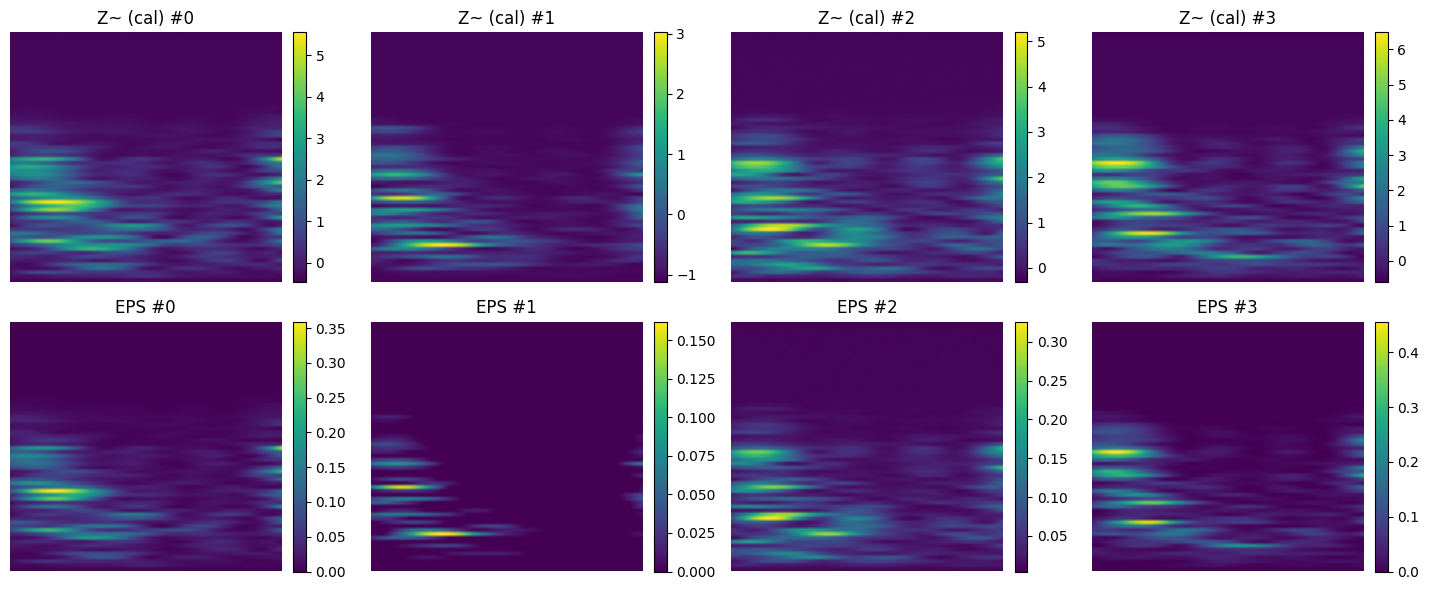

100%|██████████| 100/100 [09:54<00:00,  5.95s/it]


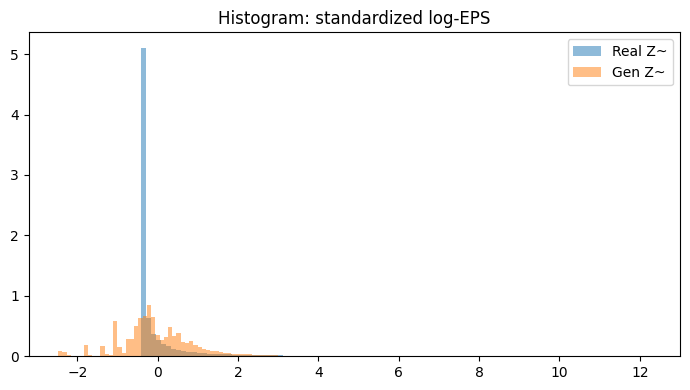

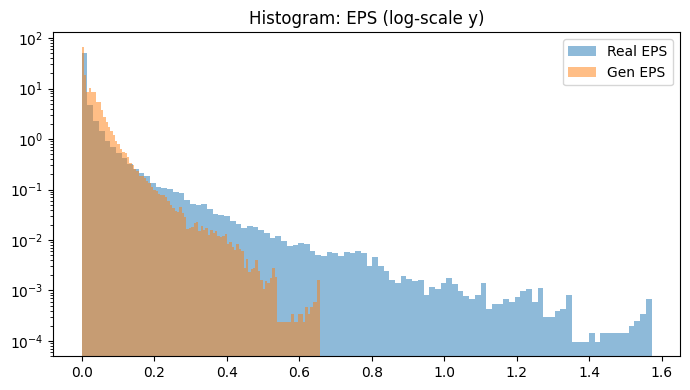

100%|██████████| 100/100 [09:54<00:00,  5.95s/it]


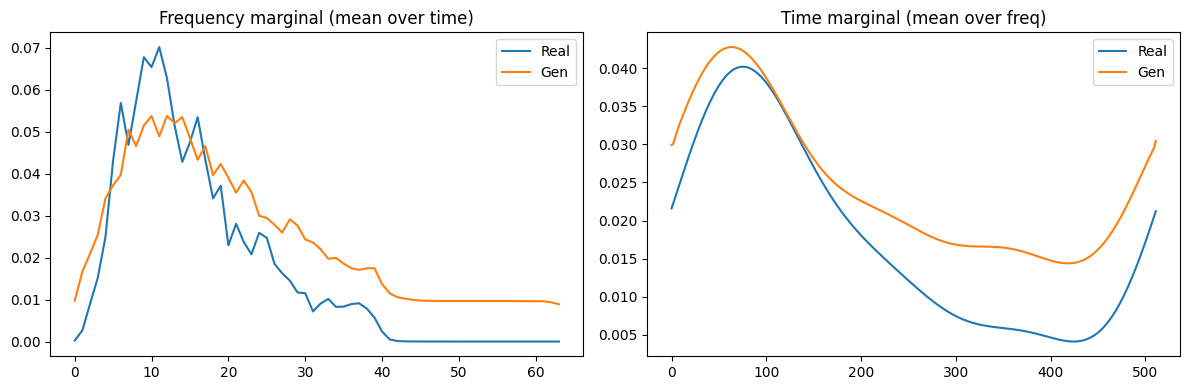

100%|██████████| 100/100 [09:54<00:00,  5.95s/it]


Wasserstein distance (EPS): 0.012502
KS test statistic: 0.3316, p-value: 0.000e+00


In [4]:
# ============================================
# Inference: load, fast settings, sample, eval
# ============================================

import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
from diffusers import UNet2DModel, DDPMScheduler

# ----------------- CONFIG -----------------
ckpt_dir = "eps_ddpm_ckpts_mem/best"  # your checkpoint dir
device   = "cuda" if torch.cuda.is_available() else "cpu"

# normalization params from training
alpha = 5.0
mu    = 0.07396781351831225
sigma = 0.17182008262835613

# ----------------- LOAD -------------------
unet = UNet2DModel.from_pretrained(ckpt_dir).to(device).eval()

# DDPM scheduler with NO CLIPPING
noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000,
    beta_start=1e-4, beta_end=0.02, beta_schedule="linear",
    prediction_type="epsilon",
    clip_sample=False,
)
# (defensive) also ensure attribute off if present
if hasattr(noise_scheduler, "clip_sample"):
    noise_scheduler.clip_sample = False

# ----------------- PERF TOGGLES -----------
torch.backends.cudnn.benchmark = True
torch.set_float32_matmul_precision("high")   # TF32 on Ampere
torch.backends.cuda.matmul.allow_tf32 = True

# (inference) disable grad checkpointing if enabled during training
try:
    unet.disable_gradient_checkpointing()
except AttributeError:
    pass

# ---- (SAFE) attention speed-up: only if your diffusers version supports it ----
try:
    from diffusers.models.attention_processor import AttnProcessor2_0
    if hasattr(unet, "set_attn_processor"):
        unet.set_attn_processor(AttnProcessor2_0())
        print("Enabled SDPA attention via AttnProcessor2_0.")
    else:
        print("Diffusers UNet lacks set_attn_processor; skipping SDPA fast attention.")
except Exception as e:
    print("Could not enable SDPA attention:", repr(e))

# ----------------- HELPERS ----------------
@torch.inference_mode()
def inverse_standardize_to_eps(z_tilde: torch.Tensor, mu: float, sigma: float, alpha: float) -> torch.Tensor:
    """
    z_tilde: (..., 64, 512) standardized log-EPS
    returns: EPS >= 0 with same trailing shape
    """
    Z = sigma * z_tilde + mu
    X = torch.expm1(Z) / alpha
    return torch.clamp(X, min=0.0)

@torch.inference_mode()
def ddpm_sample_raw(
    unet: UNet2DModel,
    scheduler: DDPMScheduler,
    n: int = 4,
    steps: int = 50,
    device: str = "cuda",
    show_progress: bool = True,
) -> torch.Tensor:
    """
    Manual DDPM sampling (no pipeline post-processing / clamping).
    Returns z_tilde in training domain, shape (n,1,64,512), torch.float32 (CPU).
    """
    scheduler.set_timesteps(steps, device=device)
    x = torch.randn((n, 1, 64, 512), device=device)
    autocast_on = device.startswith("cuda") and torch.cuda.is_available()

    it = scheduler.timesteps
    it = tqdm(it) if show_progress else it
    for t in it:
        with torch.autocast(device_type="cuda", dtype=torch.float16, enabled=autocast_on):
            eps_pred = unet(x, t).sample
        x = scheduler.step(eps_pred, t, x).prev_sample

    return x.float().cpu()

@torch.inference_mode()
def self_calibrate(z: torch.Tensor) -> torch.Tensor:
    """
    Per-batch normalization in standardized domain to fix global amplitude bias.
    Keeps inference fast (no extra sampling).
    """
    m = z.mean()
    s = z.std(unbiased=False)
    return (z - m) / (s + 1e-8)

@torch.inference_mode()
def sample_ztilde(n: int = 4, steps: int = 50, show_progress: bool = True) -> torch.Tensor:
    """
    Wrapper that samples and applies per-batch self-calibration.
    Returns (n,1,64,512) standardized log-EPS on CPU.
    """
    z = ddpm_sample_raw(unet, noise_scheduler, n=n, steps=steps, device=device, show_progress=show_progress)
    z = self_calibrate(z)   # <-- one-line amplitude fix; comment out if you don't want it
    return z

# --------------- VISUALIZATION ------------
@torch.inference_mode()
def sample_and_plot(n: int = 4, steps: int = 50, show_progress: bool = True):
    z_cal = sample_ztilde(n=n, steps=steps, show_progress=show_progress)  # (n,1,64,512)
    eps   = inverse_standardize_to_eps(z_cal, mu, sigma, alpha)

    print("z_cal range:", float(z_cal.min()), float(z_cal.max()))
    print("eps   range:", float(eps.min()),   float(eps.max()))

    B = z_cal.shape[0]
    fig, axs = plt.subplots(2, B, figsize=(3.6*B, 6))
    if B == 1: axs = np.expand_dims(axs, 1)
    for i in range(B):
        im0 = axs[0, i].imshow(z_cal[i,0], origin="lower", aspect="auto")
        axs[0, i].set_title(f"Z~ (cal) #{i}"); axs[0, i].axis("off"); plt.colorbar(im0, ax=axs[0,i], fraction=0.046, pad=0.04)
        im1 = axs[1, i].imshow(eps[i,0],  origin="lower", aspect="auto")
        axs[1, i].set_title(f"EPS #{i}");     axs[1, i].axis("off"); plt.colorbar(im1, ax=axs[1,i], fraction=0.046, pad=0.04)
    plt.tight_layout(); plt.show()

# --------- DISTRIBUTION-LEVEL CHECKS -----
try:
    from scipy.stats import wasserstein_distance, ks_2samp
    _HAS_SCIPY = True
except Exception:
    _HAS_SCIPY = False

@torch.inference_mode()
def value_histograms(real_loader, n_gen=200, steps=50, bins=100, show_progress: bool = True):
    # collect ~n_gen real standardized log-EPS
    real_batches, cnt = [], 0
    for xb in real_loader:
        real_batches.append(xb)
        cnt += xb.shape[0]
        if cnt >= n_gen: break
    if len(real_batches) == 0:
        raise RuntimeError("real_loader yielded no batches.")
    real_z = torch.cat(real_batches, dim=0)[:n_gen]           # (n_gen,1,64,512)

    gen_z = sample_ztilde(n=n_gen, steps=steps, show_progress=show_progress)  # (n_gen,1,64,512)

    # standardized domain
    rvals = real_z.cpu().numpy().ravel()
    gvals = gen_z.cpu().numpy().ravel()
    plt.figure(figsize=(7,4))
    plt.hist(rvals, bins=bins, alpha=0.5, label="Real Z~", density=True)
    plt.hist(gvals, bins=bins, alpha=0.5, label="Gen Z~",  density=True)
    plt.legend(); plt.title("Histogram: standardized log-EPS"); plt.tight_layout(); plt.show()

    # EPS domain
    real_eps = inverse_standardize_to_eps(real_z, mu, sigma, alpha).cpu().numpy().ravel()
    gen_eps  = inverse_standardize_to_eps(gen_z,  mu, sigma, alpha).cpu().numpy().ravel()
    plt.figure(figsize=(7,4))
    plt.hist(real_eps, bins=bins, alpha=0.5, label="Real EPS", density=True, log=True)
    plt.hist(gen_eps,  bins=bins, alpha=0.5, label="Gen EPS",  density=True, log=True)
    plt.legend(); plt.title("Histogram: EPS (log-scale y)"); plt.tight_layout(); plt.show()

@torch.inference_mode()
def marginals(real_loader, n_gen=200, steps=50, show_progress: bool = True):
    real_batches, cnt = [], 0
    for xb in real_loader:
        real_batches.append(xb)
        cnt += xb.shape[0]
        if cnt >= n_gen: break
    if len(real_batches) == 0:
        raise RuntimeError("real_loader yielded no batches.")
    real_z = torch.cat(real_batches, dim=0)[:n_gen]
    gen_z  = sample_ztilde(n=n_gen, steps=steps, show_progress=show_progress)

    real_eps = inverse_standardize_to_eps(real_z, mu, sigma, alpha)
    gen_eps  = inverse_standardize_to_eps(gen_z,  mu, sigma, alpha)

    # frequency marginal (mean over time)
    f_real = real_eps.mean(dim=[0,3])[0].cpu().numpy()   # (64,)
    f_gen  = gen_eps.mean(dim=[0,3])[0].cpu().numpy()
    # time marginal (mean over freq)
    t_real = real_eps.mean(dim=[0,2])[0].cpu().numpy()   # (512,)
    t_gen  = gen_eps.mean(dim=[0,2])[0].cpu().numpy()

    fig, axs = plt.subplots(1,2, figsize=(12,4))
    axs[0].plot(f_real, label="Real"); axs[0].plot(f_gen, label="Gen")
    axs[0].set_title("Frequency marginal (mean over time)"); axs[0].legend()
    axs[1].plot(t_real, label="Real"); axs[1].plot(t_gen, label="Gen")
    axs[1].set_title("Time marginal (mean over freq)"); axs[1].legend()
    plt.tight_layout(); plt.show()

@torch.inference_mode()
def distribution_distances(real_loader, n_gen=500, steps=50, show_progress: bool = True):
    if not _HAS_SCIPY:
        print("SciPy not available (pip install scipy) — skipping distances.")
        return
    real_batches, cnt = [], 0
    for xb in real_loader:
        real_batches.append(xb)
        cnt += xb.shape[0]
        if cnt >= n_gen: break
    if len(real_batches) == 0:
        raise RuntimeError("real_loader yielded no batches.")
    real_z = torch.cat(real_batches, dim=0)[:n_gen]
    gen_z  = sample_ztilde(n=n_gen, steps=steps, show_progress=show_progress)

    real_eps = inverse_standardize_to_eps(real_z, mu, sigma, alpha).cpu().numpy().ravel()
    gen_eps  = inverse_standardize_to_eps(gen_z,  mu, sigma, alpha).cpu().numpy().ravel()

    wd = wasserstein_distance(real_eps, gen_eps)
    ks = ks_2samp(real_eps, gen_eps)
    print(f"Wasserstein distance (EPS): {wd:.6f}")
    print(f"KS test statistic: {ks.statistic:.4f}, p-value: {ks.pvalue:.3e}")

# --------- SIDE-BY-SIDE (unconditional) ----
@torch.inference_mode()
def compare_real_vs_generated(loader, n: int = 4, steps: int = 50, show_progress: bool = True):
    # real batch
    it = iter(loader)
    try:
        real = next(it)[:n].to(device)
    except StopIteration:
        raise RuntimeError("loader yielded no batches.")
    # generated (standardized, calibrated)
    gen  = sample_ztilde(n=n, steps=steps, show_progress=show_progress).to(device)

    real_eps = inverse_standardize_to_eps(real, mu, sigma, alpha)
    gen_eps  = inverse_standardize_to_eps(gen,  mu, sigma, alpha)

    # simple metrics (note: unconditional — not 1:1 matches)
    mse_std = ((real - gen)**2).flatten(1).mean(dim=1).cpu().numpy()
    mae_std = (real - gen).abs().flatten(1).mean(dim=1).cpu().numpy()
    mse_eps = ((real_eps - gen_eps)**2).flatten(1).mean(dim=1).cpu().numpy()
    mae_eps = (real_eps - gen_eps).abs().flatten(1).mean(dim=1).cpu().numpy()
    for i in range(len(mse_std)):
        print(f"#{i:02d}  MSE_std={mse_std[i]:.4e}  MAE_std={mae_std[i]:.4e}   "
              f"MSE_eps={mse_eps[i]:.4e}  MAE_eps={mae_eps[i]:.4e}")

    # visualize Z~ and EPS with diffs
    real_cpu, gen_cpu = real.cpu(), gen.cpu()
    diff = gen_cpu - real_cpu
    B = real_cpu.shape[0]
    fig, axs = plt.subplots(3, B, figsize=(3.6*B, 8))
    if B == 1: axs = np.expand_dims(axs, 1)
    for i in range(B):
        im0 = axs[0, i].imshow(real_cpu[i,0], origin="lower", aspect="auto"); axs[0,i].set_title(f"Real Z~ #{i}")
        axs[0, i].axis("off"); plt.colorbar(im0, ax=axs[0,i], fraction=0.046, pad=0.04)
        im1 = axs[1, i].imshow(gen_cpu[i,0],  origin="lower", aspect="auto"); axs[1,i].set_title(f"Gen Z~ #{i}")
        axs[1, i].axis("off"); plt.colorbar(im1, ax=axs[1,i], fraction=0.046, pad=0.04)
        im2 = axs[2, i].imshow(diff[i,0],     origin="lower", aspect="auto"); axs[2,i].set_title(f"Diff Z~ #{i}")
        axs[2, i].axis("off"); plt.colorbar(im2, ax=axs[2,i], fraction=0.046, pad=0.04)
    plt.tight_layout(); plt.show()

    real_eps, gen_eps = real_eps.cpu(), gen_eps.cpu()
    diff_eps = gen_eps - real_eps
    fig, axs = plt.subplots(3, B, figsize=(3.6*B, 8))
    if B == 1: axs = np.expand_dims(axs, 1)
    for i in range(B):
        im0 = axs[0, i].imshow(real_eps[i,0], origin="lower", aspect="auto"); axs[0,i].set_title(f"Real EPS #{i}")
        axs[0, i].axis("off"); plt.colorbar(im0, ax=axs[0,i], fraction=0.046, pad=0.04)
        im1 = axs[1, i].imshow(gen_eps[i,0],  origin="lower", aspect="auto"); axs[1,i].set_title(f"Gen EPS #{i}")
        axs[1, i].axis("off"); plt.colorbar(im1, ax=axs[1,i], fraction=0.046, pad=0.04)
        im2 = axs[2, i].imshow(diff_eps[i,0], origin="lower", aspect="auto"); axs[2,i].set_title(f"Diff EPS #{i}")
        axs[2, i].axis("off"); plt.colorbar(im2, ax=axs[2,i], fraction=0.046, pad=0.04)
    plt.tight_layout(); plt.show()

# ----------------- EXAMPLES ----------------
# Quick visual check (progress bar off for speed):
sample_and_plot(n=4, steps=100, show_progress=True)

# Distribution checks (keep n_gen small for speed; steps=50 as you asked)
value_histograms(train_loader, n_gen=40, steps=100, show_progress=True)
marginals(train_loader, n_gen=40, steps=100, show_progress=True)
distribution_distances(train_loader, n_gen=40, steps=100, show_progress=True)

# Side-by-side (unconditional)
# compare_real_vs_generated(train_loader, n=4, steps=50, show_progress=False)

# Latent Diffusion Model